In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

- 세계에서 당뇨병 발병 비율이 가장 높은 애리조나 주의 피마 인디언 대상으로 조사한 데이터.
- 임신 횟수, 혈압, 당뇨병 내력, 나이 등의 변수

In [16]:
dataset = pd.read_csv('pima-indians-diabetes.csv', header = -1)
dataset.columns = ['X'+ str(i+1) for i in range(8)] + ['Y']
dataset.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [56]:
X = dataset.iloc[:, :8]
y = dataset.iloc[:, 8]

In [25]:
y.value_counts()

0    500
1    268
Name: Y, dtype: int64

# default model

In [62]:
default_xgb = xgb.XGBClassifier()
default_xgb.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

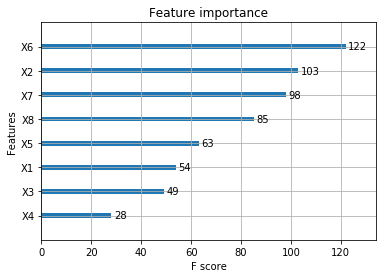

In [63]:
xgb.plot_importance(default_xgb)
plt.show()

In [28]:
from sklearn.model_selection import KFold
cv = KFold(5, shuffle=True, random_state=0)
from sklearn.metrics import f1_score 

In [99]:
default_cv = []
for i, (idx_train, idx_cv) in enumerate(cv.split(dataset)):
    df_train = dataset.iloc[idx_train]
    df_cv = dataset.iloc[idx_cv]
    
    x_train = df_train.drop(['Y'], axis=1)
    y_train = df_train['Y']
    
    x_cv = df_cv.drop(['Y'], axis=1)
    y_cv = df_cv['Y']
    
    print('-----------xgb-----------')
    default_xgb.fit(x_train, y_train)
    y_pred = default_xgb.predict(x_cv)
    print("[K = {}] train f1 = {}, cv f1 = {}".format(i, f1_score(y_train, default_xgb.predict(x_train)), f1_score(y_cv, y_pred)))
    default_cv.append(f1_score(y_cv, y_pred))
    
print('\n')
print('mean cv f1_score : ', np.mean(default_cv) )

-----------xgb-----------
[K = 0] train f1 = 0.8450704225352113, cv f1 = 0.7021276595744681
-----------xgb-----------
[K = 1] train f1 = 0.8507462686567164, cv f1 = 0.594059405940594
-----------xgb-----------
[K = 2] train f1 = 0.8291457286432161, cv f1 = 0.6779661016949152
-----------xgb-----------
[K = 3] train f1 = 0.8436724565756824, cv f1 = 0.6226415094339622
-----------xgb-----------
[K = 4] train f1 = 0.8497652582159624, cv f1 = 0.5714285714285714


mean cv f1_score :  0.6336446496145023


# hyperparameter tuning

In [38]:
import optuna
import warnings

In [70]:
hyper = {"learning_rate"    : 0.1 ,
         "max_depth"        : 3,
         "min_child_weight" : 3,
         "gamma"            : 0.1,
         "colsample_bytree" : 0.3 }

In [76]:
tuned_xgb = xgb.XGBClassifier(learning_rate=hyper['learning_rate'],
                             max_depth=hyper['max_depth'],
                             min_child_weight=hyper['min_child_weight'],
                             gamma=hyper['gamma'],
                             colsample_bytree=hyper['colsample_bytree'])

In [100]:
tuned_cv = []

for i, (idx_train, idx_cv) in enumerate(cv.split(dataset)):
    df_train = dataset.iloc[idx_train]
    df_cv = dataset.iloc[idx_cv]
    
    x_train = df_train.drop(['Y'], axis=1)
    y_train = df_train['Y']
    
    x_cv = df_cv.drop(['Y'], axis=1)
    y_cv = df_cv['Y']
    
    print('-----------xgb-----------')
    tuned_xgb.fit(x_train, y_train)
    y_pred = tuned_xgb.predict(x_cv)
    print("[K = {}] train f1 = {}, cv f1 = {}".format(i, f1_score(y_train, tuned_xgb.predict(x_train)), f1_score(y_cv, y_pred)))
    tuned_cv.append(f1_score(y_cv, y_pred))
    
print('\n')
print('mean cv f1_score : ', np.mean(tuned_cv) )

-----------xgb-----------
[K = 0] train f1 = 0.8009478672985781, cv f1 = 0.7021276595744681
-----------xgb-----------
[K = 1] train f1 = 0.8101265822784811, cv f1 = 0.48837209302325574
-----------xgb-----------
[K = 2] train f1 = 0.797979797979798, cv f1 = 0.6956521739130435
-----------xgb-----------
[K = 3] train f1 = 0.7919799498746868, cv f1 = 0.5981308411214953
-----------xgb-----------
[K = 4] train f1 = 0.8162291169451074, cv f1 = 0.5494505494505494


mean cv f1_score :  0.6067466634165624


# optimal hyperparameter

In [114]:
def xgboost_hyper(trial) :
    learning_rate = trial.suggest_uniform('learning_rate', 0,0.1)
    max_depth = trial.suggest_int('max_depth', 6,15)
    colsample_bytree = trial.suggest_uniform("colsample_bytree" , 0,0.7)
    
    opt_xgb = xgb.XGBClassifier(learning_rate=learning_rate,
                             max_depth=max_depth,
                             colsample_bytree=colsample_bytree)
    
    opt_cv = []
    #cv
    for i, (idx_train, idx_cv) in enumerate(cv.split(dataset)):
        df_train = dataset.iloc[idx_train]
        df_cv = dataset.iloc[idx_cv]

        x_train = df_train.drop(['Y'], axis=1)
        y_train = df_train['Y']

        x_cv = df_cv.drop(['Y'], axis=1)
        y_cv = df_cv['Y']

        opt_xgb.fit(x_train, y_train)
        tuned_cv.append(f1_score(y_cv, opt_xgb.predict(x_cv)))
    
    return - np.mean(tuned_cv)

In [115]:
study = optuna.create_study()
study.optimize(xgboost_hyper, n_trials=100)

[I 2019-03-06 21:40:28,678] Finished a trial resulted in value: -0.5856202362102819. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:40:29,245] Finished a trial resulted in value: -0.5849535349507804. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:40:29,736] Finished a trial resulted in value: -0.5847614607420965. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:40:31,021] Finished a trial resulted in value: -0.5848670639939498. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:40:31,654] Finished a t

[I 2019-03-06 21:40:54,851] Finished a trial resulted in value: -0.5808883338570637. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:40:55,863] Finished a trial resulted in value: -0.5808976241779736. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:40:57,107] Finished a trial resulted in value: -0.5809890066748585. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:40:57,684] Finished a trial resulted in value: -0.5804932201931965. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:40:58,534] Finished a t

[I 2019-03-06 21:41:24,044] Finished a trial resulted in value: -0.5776587408781598. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:41:25,037] Finished a trial resulted in value: -0.5776442569074905. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:41:26,163] Finished a trial resulted in value: -0.577710013210195. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:41:27,131] Finished a trial resulted in value: -0.5777160345614522. Current best value is -0.5856202362102819 with parameters: {'learning_rate': 0.07539524538827853, 'max_depth': 9, 'colsample_bytree': 0.5808244190471302}.
[I 2019-03-06 21:41:27,859] Finished a tr

In [110]:
study.best_params

{'learning_rate': 0.04885932830309282,
 'max_depth': 12,
 'colsample_bytree': 0.5161636239935973}

In [111]:
- study.best_value

0.5957985862090337